# Import librairies <a class="anchor" id="libraries"></a>

In [20]:
from dolfin import Point, FiniteElement, MixedElement, FunctionSpace, TrialFunction, TestFunction, Function, plot, split, NewtonSolver, File, assemble, dx, near
import dolfin

import os
import glob

import time
import numpy as np
import pickle
from scipy.interpolate import griddata
from mshr import Polygon, generate_mesh
from tqdm import tqdm
import pickle as pkl

from pathlib import Path
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from CoolProp.CoolProp import PropsSI

from Plot_functions import plot_wells, plot_initial_conditions, plot_extraction_data, plot_phi_k_H_depth, plot_mass, plot_well_pressure, plot_pressure_comparison
from Auxiliary_functions import precise_mesh, H_function, k_function, phi_function, depth_function, define_problem, injected_mass, day_format, well_pressure_difference_RMSE, extract_pressure_list, min_h_p
from Auxiliary_class import InitialConditions, DirichletBC

# Initialize folders

In [21]:
# Initialize time
time0 = time.time()

# Initialize folders for results
input_folder = "GRONINGEN/Inputs"
output_folder = "GRONINGEN/Outputs - Diffusion model/"
figures_output = "GRONINGEN/Figures"

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(output_folder + "/p"):
    os.mkdir(output_folder + "/p")
else:
    for fichier in glob.glob(os.path.join(output_folder + "/p", '*')):
        os.remove(fichier)

if not os.path.exists(output_folder + "/h"):
    os.mkdir(output_folder + "/h")
else:
    for fichier in glob.glob(os.path.join(output_folder + "/h", '*')):
        os.remove(fichier)
    
if not os.path.exists(figures_output):
    os.mkdir(figures_output)

# Import Groningen Data <a class="anchor" id="Groningen_data"></a>

In [22]:
# Rebuild RES dictionary
folder_RES = os.path.join(input_folder, 'RESDictionary_data')
RES = {}

# Iterate over files in that directory
for filename in os.listdir(folder_RES):
    f = os.path.join(folder_RES, filename)
    if filename[-2:] == '.p':
        RES[filename[:-2]]=pickle.load(open(f,'rb'),encoding='latin1')

# Extract reservoir data
X, Y = RES['X'],RES['Y']#np.mgrid[np.min(RES['X']):np.max(RES['X']):500, np.min(RES['Y']):np.max(RES['Y']):500]
Thickness = RES['RES']['Thickness']#np.load(folder_name + 'ReservoirThickness.npy') / 1000 #dim change
Outline = RES['Outline'][['X','Y']]
CM_grd = np.array([[3e-13 for j in range(70)] for i in range(64)]) # 3e-8 #low impact
pickle.dump(RES, open('RESDictionary.p', 'wb'))

# Wells
file_wells = os.path.join(input_folder, 'WellInformation.npy')
GasData = np.load(file_wells, allow_pickle=True).item()
GasExtractionData = GasData['AverageWinter'] # One given scenario for after 2018
Well = GasData['WellLocations'] # The wells names and coordinates

# Model parameters <a class="anchor" id="model_parameters"></a>

#### Reservoir <a class="anchor" id="reservoir"></a>

In [23]:
List_param = [] # List where all paramters will be saved

# General parameters
Temp = 102 # °C # Temperature of the reservoir
Temp += 273.15 ; List_param.append('Temperature of the reservoir') ; List_param.append(Temp) ; List_param.append('K') # K
p_ref = 8*1e6 # Pa
p_extrem = 35*1e6
g = 9.81 # m.s-2
phi = 15.5/100 # porosity
k = 264*1e-15 # permeability
Gas_column_saturation = 0.28 # gas saturation height

# Thickness and depth of the reservoir
H_points = [[RES['X'].flatten()[ii],RES['Y'].flatten()[ii]] for ii in range(len(RES['X'].flatten()))]
H_field = RES['RES']['Thickness'].flatten()
Depth_points = H_points
Depth_field = RES['RES']['Depth'].flatten()
Ones_field = Depth_field / Depth_field # Create a field with 1 values everywhere

# Permeability, Porosity, Compressibility
k_points = [[RES['X'].flatten()[ii],RES['Y'].flatten()[ii]] for ii in range(len(RES['X'].flatten()))]
k_field = Ones_field.flatten()*k
phi_points = k_points
phi_field = Ones_field.flatten()*phi
cr = 3e-11 # rock compressibility

#### Fluids <a class="anchor" id="fluids"></a>

In [24]:
# Gas Thermophysical parameters
gas_molecular_weight = 18.3815e-3
rho_g0 = p_ref * gas_molecular_weight / (8.314 * Temp)
rho_g1 = p_extrem * gas_molecular_weight / (8.314 * Temp)
cg = (rho_g1-rho_g0)/(p_extrem-p_ref)/rho_g0
mug0 = 0.25*137.071e-4 * np.exp(5.094 * (rho_g0*1e-3) **1.314 ) / 1e6 *3600
mug1 = 0.27*137.071e-4 * np.exp(5.094 * (rho_g1*1e-3) **1.314) / 1e6 *3600
cvg = (mug1-mug0)/(p_extrem-p_ref)
krg = 1 # relative permeability of gas in water region
sg = 0.01 # Gas saturation in water region

# Water Thermophysical parameters
rho_w0 = PropsSI('D', 'T', Temp, 'P', p_ref, 'WATER') # kg.m-3 # density of water
cw = PropsSI('ISOTHERMAL_COMPRESSIBILITY', 'T', Temp, 'P', 0.2*(p_extrem+p_ref), 'WATER') # Pa-1 # water compressibility
muw0 = PropsSI('V', 'T', Temp, 'P', p_ref, 'WATER') # Pa.s # viscosity of water
muw1 = PropsSI('V', 'T', Temp, 'P', p_extrem, 'WATER')
cvw = (muw1-muw0)/(p_extrem-p_ref)
krw = 0.071 # Relative water permeability in water region

def rho_g(p): return(rho_g0*(1+cg*(p-p_ref)))
def rho_w(p): return(rho_w0*(1+cw*(p-p_ref)))
def mug(p): return(mug0+cvg*(p-p_ref))
def muw(p): return(muw0+cvw*(p-p_ref))

#### Simulation parameters <a class="anchor" id="simu_parameters"></a> 

In [25]:
minute = 60 ; hour = 60*minute ; day = 24*hour ; year = 365*day ; month = year/12

dt = 1*day
dt_max = 20*day
T_start = 9*year # Beginning of the simulation
T_end = 75*year # End of the simulation

# Sources <a class="anchor" id="sources"></a> 

In [26]:
density_amb = 101325 * gas_molecular_weight / (8.314 * 293) # perfect gas law
# density_amb = 0.7645746 # value
# Read from reservoir data
Sources_g = []

for ii in range(GasExtractionData.shape[1]):
    Rates = -GasExtractionData[Well[ii,0]].values*density_amb/(30.4375*24*3600) # rate must be given in kg.s-1
    CoordsX = float(Well[ii,1])
    CoordsY = float(Well[ii,2])
    Times = [[t*month+dt,(t+1)*month] for t in range(GasExtractionData.shape[0])]
    Sources_g.append([[CoordsX,CoordsY],Rates,Times])

sigma = 2000 # m # source term standard deviation

# Meshgrid and model settings <a class="anchor" id="meshgrid"></a> 

Number of cells =  1320


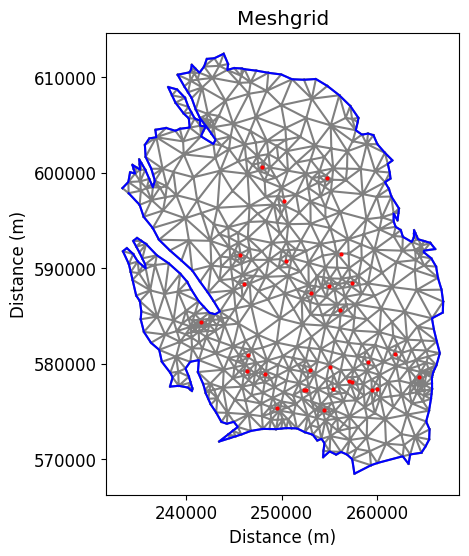

In [27]:
# Create mesh and build function space 
N_freq1 = 50 # Frequency of points selected. A low N_freq1 increases the precision of the outline
Outline_rsrvr = [Point(x,y) for x,y in zip(reversed(RES['Outline']['X'].values[0::N_freq1]),reversed(RES['Outline']['Y'].values[0::N_freq1]))] 
Outline_rsrvr.append(Point(RES['Outline']['X'].values[0],RES['Outline']['Y'].values[0]))

domain = Polygon(Outline_rsrvr)
Nm =  10 # define the global mesh fineness
mesh = generate_mesh(domain, Nm)

points_wells = []
for i in range(len(Sources_g)): points_wells.append(Point(Sources_g[i][0][0], Sources_g[i][0][1]))

N_wells = 1 # 1
radius = 2000 # The meshgrid will be refined N_wells1 times inside circles of radius=radius1, centered in well locations1
mesh = precise_mesh(mesh, points_wells, N_wells, radius)
mesh = precise_mesh(mesh, points_wells, 1, 500)
# mesh = precise_mesh(mesh, Outline_rsrvr, points_wells, 1, 200)
print('Number of cells = ', mesh.num_cells())

# Define finite elements
P1 = FiniteElement('Lagrange', mesh.ufl_cell(), 2)
element_mixte = MixedElement([P1, P1])

# Creat space functions
ME = FunctionSpace(mesh, element_mixte)
ME1 = FunctionSpace(mesh, P1)

# Tabuler les coordonnées des points du maillage
mesh_points = ME1.tabulate_dof_coordinates()

# Plot 
Outline_rsrvr = [[point[0], point[1]] for point in Outline_rsrvr]
Outline_rsrvr_array = np.array(Outline_rsrvr)
plt.figure(figsize=(5,6))
plot(mesh)
plt.title('Meshgrid')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.plot(Outline_rsrvr_array[:, 0], Outline_rsrvr_array[:, 1], color='blue', label='Reservoir outline')
plot_wells(Sources_g, 'red')
filename = 'Meshgrid.png'
plt.savefig(os.path.join(figures_output, filename), dpi=300)

# Initial conditions <a class="anchor" id="initial_conditions"></a> 

#### Prepare functions and define initial conditions <a class="anchor" id="prepare"></a> 

In [28]:
# Prepare functions
du    = TrialFunction(ME)
v  = TestFunction(ME)

u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

dp, dh = split(du)
p,  h  = split(u)
p0, h0 = split(u0)
v_h, v_p = split(v)

# Initial conditions
XX = RES['X'].flatten() ; YY = RES['Y'].flatten()
# Initial pressure
p_points = np.array([[xx,yy] for xx,yy in zip(XX,YY)])
p_init = 34.45e6
p_field = p_init*Ones_field.flatten()
# Initial thickness of gas
h_points = np.array([[xx,yy] for xx,yy in zip(XX,YY)])
h_field = Gas_column_saturation*H_field.flatten()

#### Interpolate initial conditions <a class="anchor" id="interpolate"></a> 

Removing nan values...


100%|██████████| 2887/2887 [00:00<00:00, 37479.28it/s]

...removed


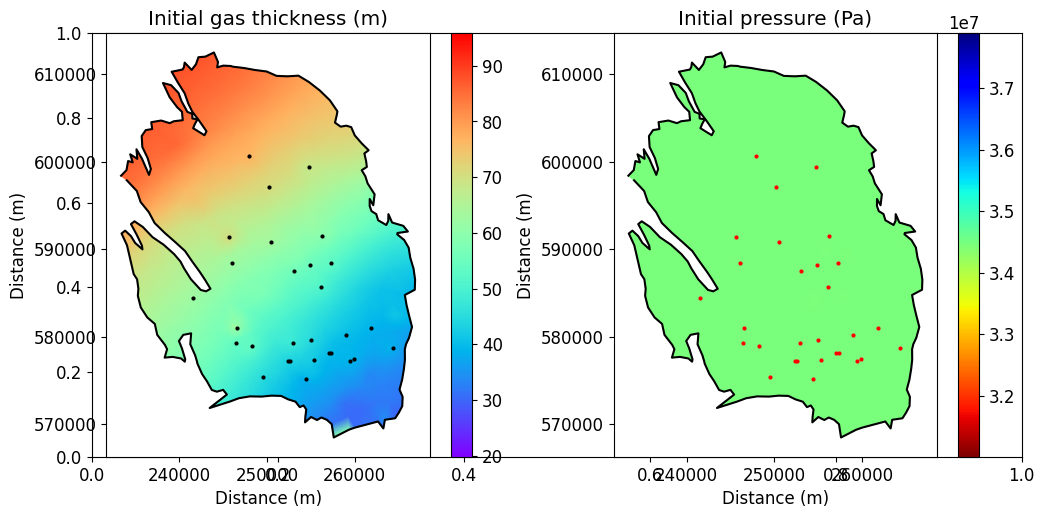

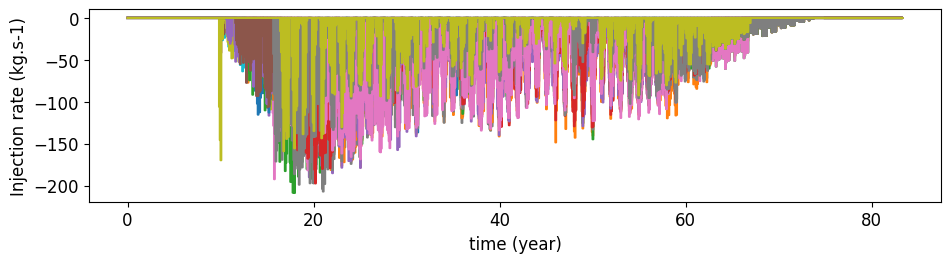

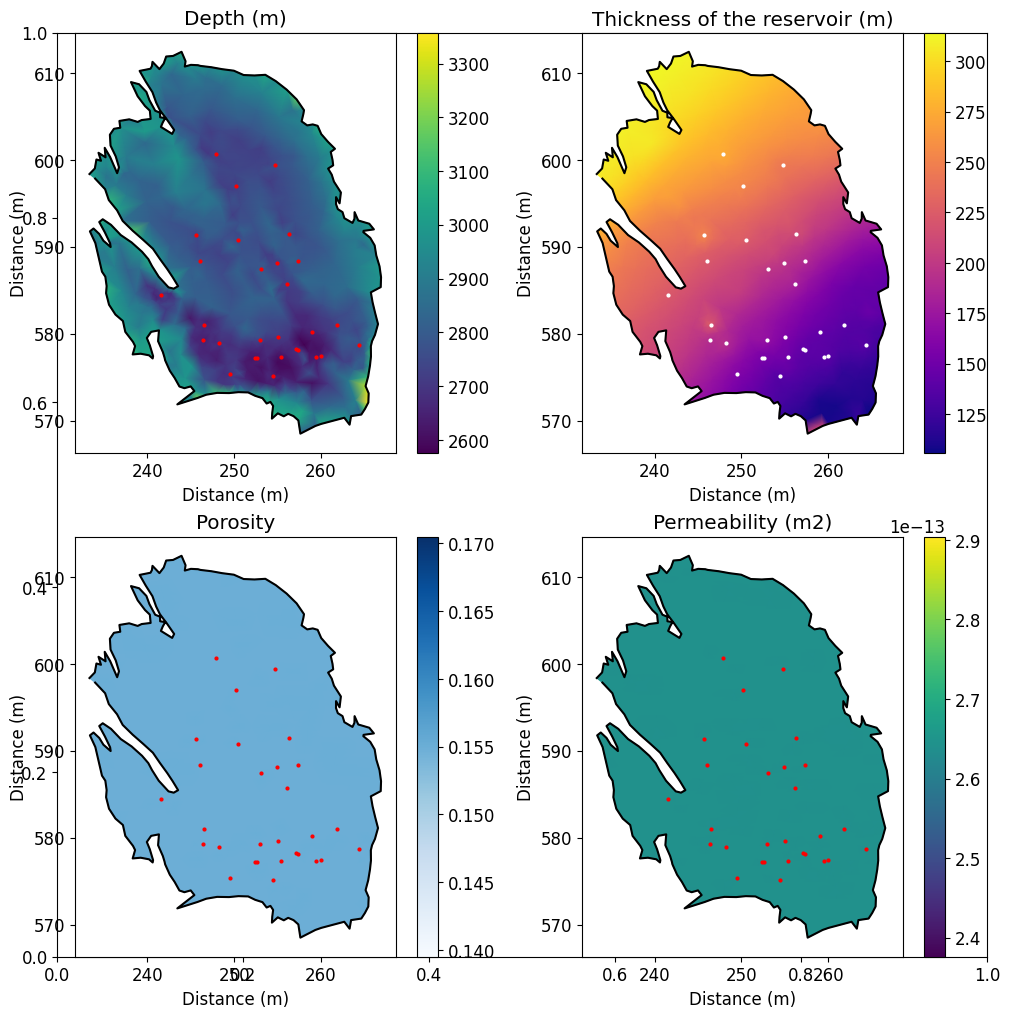

In [29]:
Coords = ME1.tabulate_dof_coordinates()

# All the data are interpolated using radial basis function interpolation (RBF)
p_init = griddata(p_points, p_field, ME1.tabulate_dof_coordinates(), method='linear') # Pressure
h_init = griddata(h_points, h_field, ME1.tabulate_dof_coordinates(), method='linear') # gas thickness

# Interpolate reservoir data
Hf = H_function(H_points, H_field, ME1, 'griddata') ; H_max = np.amax(Hf.vector().get_local())
kf = k_function(k_points, k_field, ME1, 'griddata')
phif = phi_function(phi_points, phi_field, ME1, 'griddata')
depthf = depth_function(Depth_points, Depth_field, ME1, 'griddata')

# Remove 'nan' values
print('Removing nan values...')
for i in tqdm(range(len(mesh_points))):
    if np.isnan(Hf.vector().get_local()[i]): Hf.vector().get_local()[i] = np.nanmean(Hf.vector().get_local())
    if np.isnan(p_init[i]) and not np.isnan(p_init[i-1]): p_init[i] = p_init[i-1]
    elif np.isnan(p_init[i]): p_init[i] = p_extrem
    if np.isnan(h_init[i]) : h_init[i] = np.nanmax([Gas_column_saturation*Hf.vector().get_local()[i], 0])
    if h_init[i]<=1e-1: h_init[i] = np.nanmax([Gas_column_saturation*Hf.vector().get_local()[i], 0])
print('...removed')

# Interpolate initial conditions
u_init = InitialConditions(p_init, h_init, Coords, ME1)
u.interpolate(u_init)
u0.interpolate(u_init)

# Plot
plot_initial_conditions(figures_output, Sources_g, u, h_field, Outline_rsrvr_array)
plot_extraction_data(figures_output, Sources_g, T_end)
plot_phi_k_H_depth(figures_output, Sources_g, Outline_rsrvr_array, kf, Hf, phif, depthf)

# Boundary conditions

In [30]:
use_boundary = False

if use_boundary:
    u_bound = InitialConditions(p_init, h_init, Coords, ME1)

    def boundary_L(x, on_boundary):
        tol = 1000
        if on_boundary:
            for vertice in Outline_rsrvr_array:
                if near(x[0], vertice[0], tol) and near(x[1], vertice[1], tol):
                    return True
        return False

    bc = DirichletBC(ME, u_bound, boundary_L)
    bcs = [bc]
else:
    bcs = []

# Define problem <a class="anchor" id="define_problem"></a> 

In [31]:
# Time parameters
t = T_start
Nt = 0
List_t = [t]

# Define problem
problem = define_problem(dt, t,
                         Sources_g,
                         ME1,
                         Hf, phif, sg, g,
                         rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                         cr, cg, cw,
                         u, p, h, p0, h0, du,
                         sigma,
                         v_p, v_h,
                         kf, krg, krw, bcs)

PArray_ = np.zeros((mesh.coordinates().shape[0],1))  
vertex_values_P_ = u0.compute_vertex_values(mesh)
PArray_[:, 0] = vertex_values_P_[:int(len(vertex_values_P_)/2)]

# Solver parameters
solver = NewtonSolver() # Parameters recommended for non linear solver
solver_parameters={"linear_solver": "mumps"} # , superlu_dist, lu
dolfin.parameters['form_compiler']['optimize'] = True
dolfin.parameters['form_compiler']['cpp_optimize'] = True
solver.parameters["relative_tolerance"] = 1e-1
solver.parameters["absolute_tolerance"] = 1e-1
solver.parameters["maximum_iterations"] = 20

# Main loop (data saved in the main loop) <a class="anchor" id="main_loop"></a> 

In [32]:
u_plot = Function(ME)  # current solution
p_plot, h_plot = split(u_plot)

# Prepare folder to save results   
file_p = File (output_folder + "/p" + "/output_p.pvd")
file_h = File (output_folder + "/h" + "/output_h.pvd")
file_p << u.split()[0] ; file_h << u.split()[1]
file_H = File (output_folder + "/H.pvd") ; file_H << Hf

Mass_found0 = phi*assemble(rho_g(p)*(h+(Hf-h)*sg)*dx)
Previous_mass = Mass_found0 ; Previous_expected = injected_mass(0, Sources_g)
List_expected_extracted_mass = [Previous_expected] ; List_found_extracted_mass = [0]
List_err1 = [0] # Create list to save relative difference of CO2 mass (between injected and found)
time1 = time.time() # Save current time to calulate loop duration

while (t < T_end):
    print(Fore.BLUE+'# Iteration '+str(Nt))
    print('# t = '+day_format(t)+' / '+day_format(T_end))
    print('dt = ' + day_format(dt))
    print(Style.RESET_ALL)
    t += dt
    
    u0.vector()[:] = u.vector()[:]
    (no_of_iterations,converged) = solver.solve(problem, u.vector())
    
    Mass_found = phi*assemble(rho_g(p)*(h+(Hf-h)*sg)*dx)
    print(Fore.RED+str(Mass_found0)+" # "+str(Mass_found)+" # "+str(Mass_found/Mass_found0))
    Expected_injected_mass = injected_mass(t, Sources_g)
    List_expected_extracted_mass.append(Expected_injected_mass*1e-9)
    List_found_extracted_mass.append((Mass_found-Mass_found0)*1e-9)
    if no_of_iterations > 5 : dt /= 16
    elif no_of_iterations > 4 : dt /= 8
    elif dt<dt_max/1.4 : dt *= 1.4
    
    # Redefine the problem with new values
    problem = define_problem(dt, t,
                             Sources_g,
                             ME1,
                             Hf, phif, sg, g,
                             rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                             cr, cg, cw,
                             u, p, h, p0, h0, du,
                             sigma,
                             v_p, v_h,
                             kf, krg, krw, bcs)
    Nt += 1 ; List_t.append(t)
    file_p << u.split()[0] ; file_h << u.split()[1]
    print(Fore.GREEN + 'Total expected injected/extracted mass at t = ' + day_format(t) + " : " + str(Expected_injected_mass*1e-9) + ' Mt')
    print(Fore.GREEN + 'Total injected/extracted mass found at t = ' + day_format(t) + " : " + str((Mass_found-Mass_found0)*1e-9) + ' Mt')
    if Expected_injected_mass != 0:
        print(Fore.GREEN + 'Relative difference = ' + str(100*((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass)) + ' %')
        List_err1.append(((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass))
    else : List_err1.append(0)
    
    vertex_values_P_ = u0.compute_vertex_values(mesh)
    z = np.zeros((int(len(vertex_values_P_)/2), 1))
    for i in range(int(len(vertex_values_P_)/2)): z[i]= vertex_values_P_[:int(len(vertex_values_P_)/2)][i]
    PArray_ = np.append(PArray_, z, axis=1)
            
timef = time.time()

# Iteration 0
# t = 9.0 years / 75.0 years
dt = 1.0 days

Newton iteration 0: r (abs) = 8.432e+05 (tol = 1.000e-01) r (rel) = 1.000e+00 (tol = 1.000e-01)
1934311077054.0835 # 1934311076988.5527 # 0.9999999999661219
Newton iteration 1: r (abs) = 5.600e+01 (tol = 1.000e-01) r (rel) = 6.641e-05 (tol = 1.000e-01)
Newton solver finished in 1 iterations and 1 linear solver iterations.
Total expected injected/extracted mass at t = 9.0 years : -0.0006802754632264474 Mt
Total injected/extracted mass found at t = 9.0 years : -6.553076171875e-08 Mt
Relative difference = 99.99036701204984 %
# Iteration 1
# t = 9.0 years / 75.0 years
dt = 1.3 days

Newton iteration 0: r (abs) = 9.558e+05 (tol = 1.000e-01) r (rel) = 1.000e+00 (tol = 1.000e-01)
1934311077054.0835 # 1934311076962.6738 # 0.999999999952743Newton iteration 1: r (abs) = 1.907e+01 (tol = 1.000e-01) r (rel) = 1.996e-05 (tol = 1.000e-01)
Newton solver finished in 1 iterations and 1 linear solver iterations.

Total expected injected/extracted

# Loop data <a class="anchor" id="loop_data"></a> 

Number of iteration = 1639
loop time = 6 min
total time = 7 min



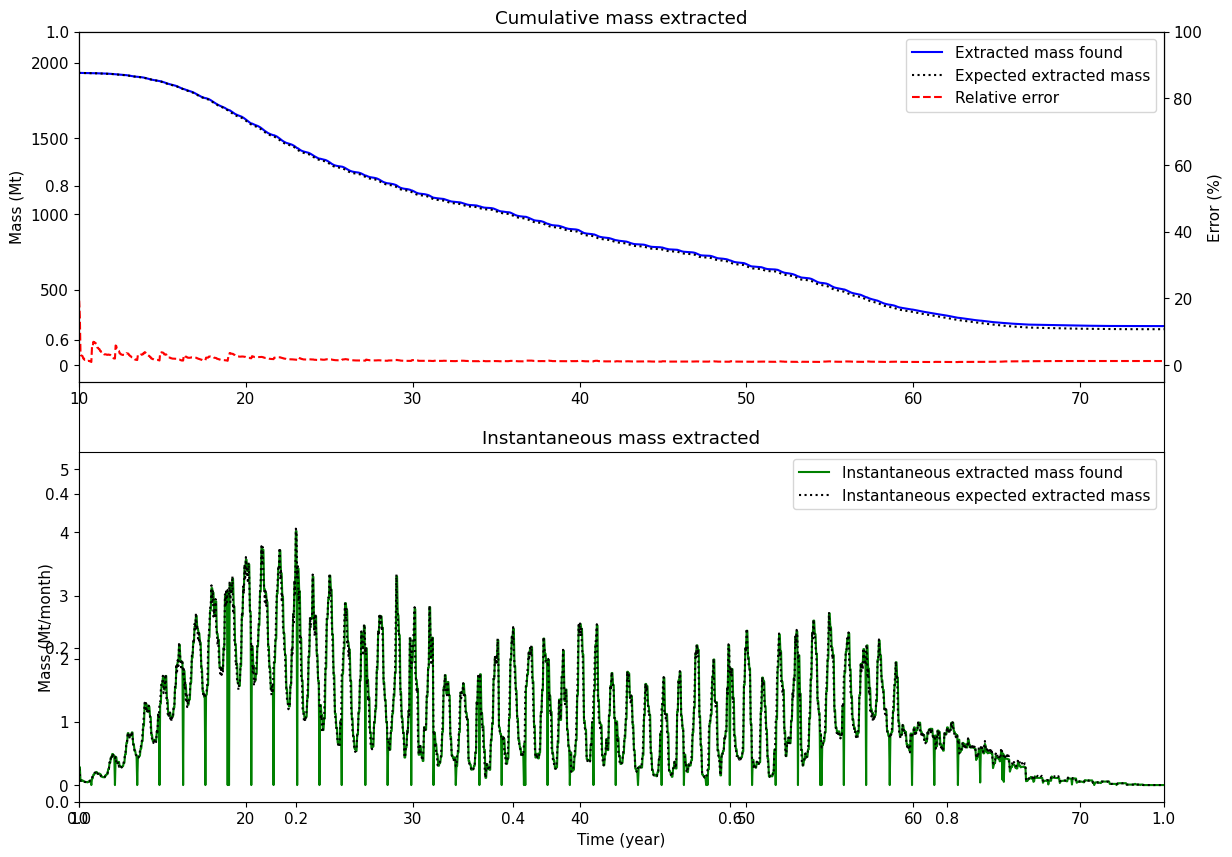

In [33]:
print(Fore.BLUE + 'Number of iteration = ' + str(Nt))
print(Fore.GREEN + 'loop time = ' + day_format(timef - time1))
print(Fore.GREEN + 'total time = ' + day_format(timef - time0))
print(Style.RESET_ALL)

plot_mass(figures_output, Nt, List_t, timef, time1, time0, Mass_found0, List_expected_extracted_mass, List_found_extracted_mass, Outline_rsrvr_array, T_end, List_err1)

# Save and display results <a class="anchor" id="save_display"></a> 

In [37]:
# --------- Display RMSE and MAE ------------------------------------------------------------------------------------------
List_index = []
for i in range(Well.shape[0]):
    xw = int(Well[i][1]) ; yw = int(Well[i][2])
    index = 0
    dmin = (mesh.coordinates()[0][0]-xw)**2+(mesh.coordinates()[0][1]-yw)**2
    for j in range(1, len(mesh.coordinates())):
        d = (mesh.coordinates()[j][0]-xw)**2+(mesh.coordinates()[j][1]-yw)**2
        if d<dmin :
            dmin = d ; index = j
    List_index.append(index)

BottomHP = GasData['PressureMeasurements']
Well = GasData['WellLocations']
RMSE = well_pressure_difference_RMSE(List_index, Nt, List_t, Well, BottomHP, PArray_)[2]
print('RMSE = ', RMSE)

RMSE =  0.5948311119604963


100%|██████████| 1640/1640 [00:11<00:00, 139.71it/s]


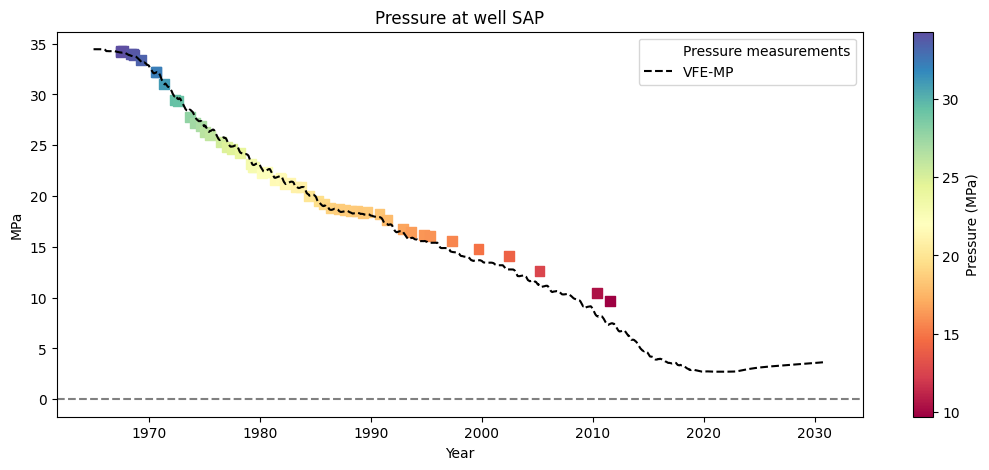

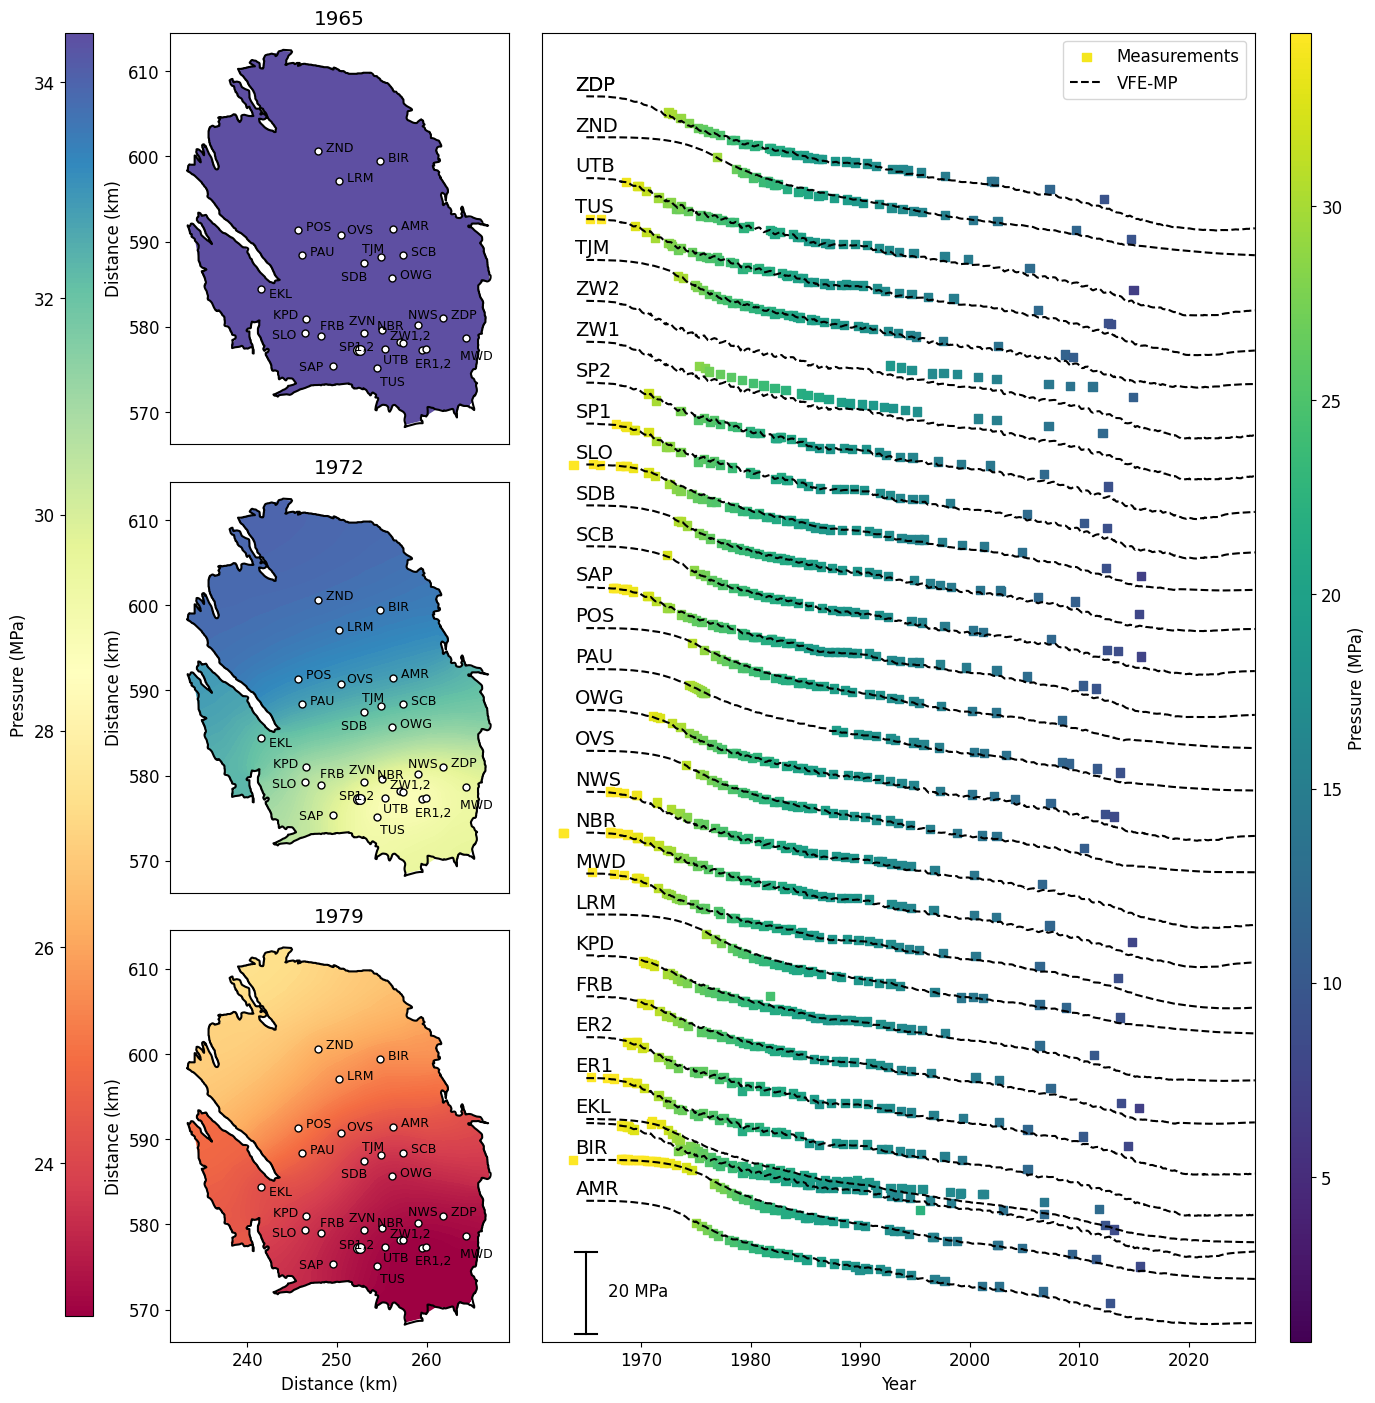

In [35]:
# --------- Define the times we are interested in -------------------------------------------------------------------------
N_plot = range(1, Nt)[::(int(Nt/9)+1)]
plt.rcParams.update({'font.size': 10})

# --------- Search for min and max pressure at the interface among these times (for colorbars scale) ----------------------
p_min, p_max, h_min, h_max = min_h_p(output_folder, N_plot)
offset = 1e3
x_min, y_min = np.min(RES['Outline']['X'].values)-offset, np.min(RES['Outline']['Y'].values)-offset
x_max, y_max = np.max(RES['Outline']['X'].values)+offset, np.max(RES['Outline']['Y'].values)+offset

# ---------- Plot ---------------------------------------------------------------------------------------------------------
plot_well_pressure(figures_output, List_index, Nt, List_t, Well, 'SAP', BottomHP, PArray_, year)
plot_pressure_comparison(output_folder, figures_output, N_plot, GasData, mesh, RES, Nt, List_t, x_min, x_max, y_min, y_max)

# Export data for mechanical model

In [36]:
# --------- Rebuild data --------------------------------------------------------------------------------------------------
xmin = np.nanmin(X) ; xmax = np.nanmax(X)
ymin = np.nanmin(Y) ; ymax = np.nanmax(Y)

N1 = 54 ; N2 = 49
XMesh = [] ; YMesh = []
for i in range(N1): XMesh_tamp = [xmin+(xmax-xmin)*j/(N2-1) for j in range(N2)] ; XMesh.append(XMesh_tamp)
for i in range(N1): YMesh_tamp = [ymin+(ymax-ymin)*i/(N1-1) for j in range(N2)] ; YMesh.append(YMesh_tamp)

X_, Y_ = np.meshgrid(np.array(XMesh)[0], np.array(YMesh)[:,0])
Thick = griddata(H_points, H_field, (X_, Y_), method='linear')
Depth = griddata(Depth_points, Depth_field, (X_, Y_), method='linear') # depth_points are the same as H_points
dRES = {'Depth':Depth, 'Thickness': Thick}
CM_grd = np.array([[3e-13 for j in range(N1)] for i in range(N2)]) # 3e-8 #low impact
dCm = {'Cm':CM_grd}

# --------- Export other data ------------------------------------------------------------------------------------------------
path = Path("Diffusion_model.ipynb")

np.save(os.path.join(output_folder, 'MESH.npy'), np.array(mesh.coordinates())) # Export MESH

extract_pressure_list(output_folder, Nt)
pkl.dump(np.array(List_t), open(output_folder + 'List_t.p', 'wb'))

100%|██████████| 1639/1639 [00:12<00:00, 126.73it/s]
